In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score # Please note that this is the only sklearn function that can be utilized.
from collections import Counter
import sys
sys.setrecursionlimit(5000)

# Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the train/val/test dataset

df_train = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Pattern_Recognition/hw3/PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Pattern_Recognition/hw3/PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Pattern_Recognition/hw3/PR_HW3_Test.csv"))

X_train = df_train[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_train = df_train["Target"].to_numpy().astype(int)

X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_val = df_val["Target"].to_numpy().astype(int)

X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_test = df_test["Target"].to_numpy().astype(int)

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(800, 7)
(800,)
(800, 7)
(800,)
(800, 7)
(800,)


# Model Implementation

In [5]:
def gini(sequence):
  unique_value, value_counts = np.unique(sequence, return_counts=True)
  sum = 0
  for i in range(len(value_counts)):
    rate = value_counts[i]/len(sequence)
    sum += (rate*rate)
    
  return 1-sum


def entropy(sequence):
  unique_value, value_counts = np.unique(sequence, return_counts=True)
  sum = 0
  for i in range(len(value_counts)):
    rate = value_counts[i]/len(sequence)
    sum += (rate*np.log2(rate))

  return -sum
    

In [6]:
class Node():
    """
        You can add/change any variables/methods to meet your need.
    """
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None,predicted_class=None):       
      self.feature_idx = feature_idx
      self.threshold = threshold
      self.left = left
      self.right = right
      self.predicted_class = predicted_class

    def is_leaf_node(self):
      return self.predicted_class is not None

In [7]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, max_features=None):
        
        """
            You can add/change any variables/methods to meet your need.
        """

        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        
        if max_depth is None:
            self.max_depth = 1e9
        else:
            self.max_depth = max_depth

        self.importance = {}
        self.tree = None
        self.max_features = max_features

    def fit(self, X, y):
      for i in range(X.shape[1]):
        feature_name = 'Feature' + str(i+1)
        self.importance[feature_name] = 0
      self.tree = self.grow_tree(X, y, 0)

    def predict(self, X):
      predictions = []
      for row in X:
        node = self.tree
        # if node.left is None, it is leaf node
        while True:
          if node.is_leaf_node():
            predictions.append(node.predicted_class)
            break

          if row[node.feature_idx] <= node.threshold:
            node = node.left
          else:
            node = node.right

      return np.array(predictions)

    def countImportance(self):
        pass

    def select_best_split(self, X, y):
      best_feature_idx = None
      best_threshold = None
      best_info_gain = -1
      base_gain = self.criterion(y)
      feature_idx_list = self.sample_features(X.shape[1])

      for feature_idx in feature_idx_list:
        values = np.unique(X[:, feature_idx])
        for threshold in values:
          left_idxs = X[:, feature_idx] <= threshold
          right_idxs = X[:, feature_idx] > threshold
          left_class = y[left_idxs]
          right_class = y[right_idxs]
          left_gain = self.criterion(left_class)
          right_gain = self.criterion(right_class)
          total_gain = (len(left_class) * left_gain + len(right_class) * right_gain) / X_train.shape[0]
          info_gain = base_gain - total_gain

          if len(left_idxs) == 0 or len(right_idxs) == 0:
            info_gain = 0

          if info_gain > best_info_gain:
            best_feature_idx = feature_idx
            best_threshold = threshold
            best_info_gain = info_gain

      return best_feature_idx, best_threshold

    def grow_tree(self, X, y, depth):
      n_samples, n_features = X.shape
      n_classes = len(np.unique(y))

      # if depth reach max_depth, return leaf node
      if depth>=self.max_depth or n_classes==1 or n_samples<2:
        leaf_predicted_class = np.bincount(y).argmax()
        return Node(predicted_class=leaf_predicted_class)
      
      # choose best split
      best_feature_idx, best_threshold = self.select_best_split(X, y)

      # create child nodes
      left_idxs = X[:, best_feature_idx] <= best_threshold
      right_idxs = X[:, best_feature_idx] > best_threshold

      # if only have one child node, return leaf node
      if len(y[left_idxs])==0 or len(y[right_idxs])==0:
        leaf_predicted_class = np.bincount(y).argmax()
        return Node(predicted_class=leaf_predicted_class)

      left = self.grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
      right = self.grow_tree(X[right_idxs, :], y[right_idxs], depth+1)

      feature_name = 'Feature' + str(best_feature_idx+1)
      self.importance[feature_name] += 1

      return Node(best_feature_idx, best_threshold, left, right)

    def sample_features(self, n_features):
      if self.max_features is None:
        return np.arange(n_features)
      else:
        return np.random.choice(n_features, self.max_features, replace=False)


In [8]:
class RandomForest():
    """
        You can add/change any variables/methods to meet your need.
    """
    def __init__(self, n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None):
        
      self.n_estimators = n_estimators
      self.max_features = max_features
      self.boostrap = boostrap
      self.criterion = criterion
      self.max_depth = max_depth
      self.trees = []
        
    def fit(self, X, y):
      for i in range(self.n_estimators):
        tree = DecisionTree(criterion=self.criterion, max_features=self.max_features, max_depth=self.max_depth)
        X_samp, y_samp = self.bootstrap_sample(X, y)
        tree.fit(X_samp, y_samp)
        self.trees.append(tree)

    def predict(self, X):
      # majority vote
      predictions = np.zeros((X.shape[0], self.n_estimators))
      for i, tree in enumerate(self.trees):
        predictions[:, i] = tree.predict(X)

      # find majority for each row
      most_common_labels = [Counter(row).most_common(1)[0][0] for row in predictions]
      return np.array(most_common_labels)

    def bootstrap_sample(self, X, y):
      if not self.boostrap:
        return X, y
      else:
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
      return X[idxs], y[idxs]

# Questions for Decision Tree

In [9]:
# For Q1
ex1 = np.array(["+", "+", "+", "+", "+", "-"])
ex2 = np.array(["+", "+", "+", "-", "-", "-"])
ex3 = np.array(["+" ,"-", "-", "-", "-", "-"])

print(f"{ex1}: entropy = {entropy(ex1)}\n{ex2}: entropy = {entropy(ex2)}\n{ex3}: entropy = {entropy(ex3)}\n")
print(f"{ex1}: gini index = {gini(ex1)}\n{ex2}: gini index = {gini(ex2)}\n{ex3}: gini index = {gini(ex3)}\n")

['+' '+' '+' '+' '+' '-']: entropy = 0.6500224216483541
['+' '+' '+' '-' '-' '-']: entropy = 1.0
['+' '-' '-' '-' '-' '-']: entropy = 0.6500224216483541

['+' '+' '+' '+' '+' '-']: gini index = 0.2777777777777777
['+' '+' '+' '-' '-' '-']: gini index = 0.5
['+' '-' '-' '-' '-' '-']: gini index = 0.2777777777777777



In [10]:
# For Q2-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0) # You may adjust the seed number in all the cells

dt_depth3 = DecisionTree(criterion='gini', max_features=None, max_depth=3)
# dt_depth3 = DecisionTree(max_depth=3)
dt_depth3.fit(X_train, y_train)

acc = accuracy_score(y_val, dt_depth3.predict(X_val))

print("Q2-1 max_depth=3: ", acc)

Q2-1 max_depth=3:  0.73125


In [11]:
"""
    Updated as of 20:30 on Apr. 22.
    The accuracy assertion has been removed. However, you can still use Sklearn's accuracy metric to evaluate the correctness of your implementation.
"""

# """ Do Not Modify Below """

from sklearn.tree import DecisionTreeClassifier as SK_DecisionTreeClassifier

sk_dt = SK_DecisionTreeClassifier(criterion='gini', max_depth=3)
sk_dt.fit(X_train, y_train)
sk_acc = accuracy_score(y_val, sk_dt.predict(X_val))
print(sk_acc)

# assert round(acc, 3) == round(sk_acc, 3), "Because the Decision Tree without any trick has a fixed answer, your accuracy should be the same as sklearn, otherwise your implementation might have some problems"

0.73125


In [12]:
# For Q2-2, validation accuracy should be higher than or equal to 0.85

np.random.seed(0)

dt_depth10 = DecisionTree(criterion='gini', max_features=None, max_depth=10)
dt_depth10.fit(X_train, y_train)

print("Q2-2 max_depth=10: ", accuracy_score(y_val,  dt_depth10.predict(X_val)))

Q2-2 max_depth=10:  0.86375


In [13]:
# For Q3-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0)

dt_gini = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_gini.fit(X_train, y_train)

print("Q3-1 criterion='gini': ", accuracy_score(y_val, dt_gini.predict(X_val)))


Q3-1 criterion='gini':  0.73125


In [14]:
# For Q3-2, validation accuracy should be higher than or equal to 0.77

np.random.seed(0)

dt_entropy = DecisionTree(criterion='entropy', max_features=None, max_depth=3)
dt_entropy.fit(X_train, y_train)

print("Q3-2 criterion='entropy': ", accuracy_score(y_val, dt_entropy.predict(X_val)))

Q3-2 criterion='entropy':  0.76875


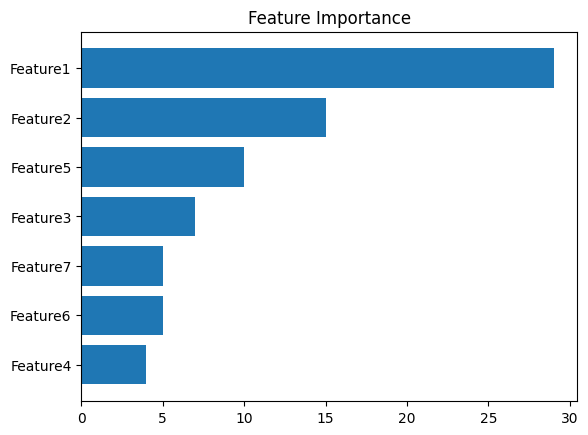

In [15]:
# For Q4

# Use simply counting to get the feature importance: dt_depth10.importance
data = dt_depth10.importance
sorted_values = sorted(data.values())
sorted_keys = [key for key, value in sorted(data.items(), key=lambda item: item[1])]

plt.barh(sorted_keys, sorted_values)
plt.title('Feature Importance')
plt.show()

# Questions for Random Rorest

In [16]:
# For Q5-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(0)

rf_estimators10 = RandomForest(n_estimators=10, max_features=int(np.sqrt(X_train.shape[1])), boostrap=True, criterion='gini', max_depth=None)
rf_estimators10.fit(X_train, y_train)

print("Q5-1 n_estimators=10: ", accuracy_score(y_val, rf_estimators10.predict(X_val)))

Q5-1 n_estimators=10:  0.88625


In [17]:
# For Q5-2, validation accuracy should be higher than or equal to 0.89

np.random.seed(0)

rf_estimators50 = RandomForest(n_estimators=50, max_features=int(np.sqrt(X_train.shape[1])), boostrap=True, criterion='gini', max_depth=None)
rf_estimators50.fit(X_train, y_train)

print("Q5-2 n_estimators=50: ", accuracy_score(y_val, rf_estimators50.predict(X_val)))

Q5-2 n_estimators=50:  0.9


In [18]:
# For Q6-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(0)

rf_maxfeature_sqrt = RandomForest(n_estimators=10, max_features=int(np.sqrt(X_train.shape[1])), boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_sqrt.fit(X_train, y_train)

print("Q6-1 max_features='sqrt': ", accuracy_score(y_val,  rf_maxfeature_sqrt.predict(X_val)))

Q6-1 max_features='sqrt':  0.88625


In [19]:
# For Q6-2, validation accuracy should be higher than or equal to 0.86

np.random.seed(0)

rf_maxfeature_none = RandomForest(n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_none.fit(X_train, y_train)

print("Q6-2 max_features='All': ", accuracy_score(y_val, rf_maxfeature_none.predict(X_val)))

Q6-2 max_features='All':  0.87


# Train your own model

In [27]:
print("your_model: ", accuracy_score(y_train, your_model.predict(X_train)))

your_model:  1.0


In [26]:
# Build and train your model
np.random.seed(2022)

your_model = RandomForest(n_estimators=100, max_features=1, boostrap=True, criterion='gini', max_depth=None)
your_model.fit(X_train, y_train)
print("your_model: ", accuracy_score(y_val, your_model.predict(X_val)))

your_model:  0.91


In [21]:
test_pred = your_model.predict(X_test)

print("test_pred shape: ", test_pred.shape)

test_pred shape:  (800,)


In [22]:
"""
    Updated as of 20:30 on Apr. 22.
    We have modified the baseline score, please check the HW3 slide.
"""

'\n    Updated as of 20:30 on Apr. 22.\n    We have modified the baseline score, please check the HW3 slide.\n'

In [23]:
# # output csv
df_test  = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Pattern_Recognition/hw3/PR_HW3_Test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("/content/drive/MyDrive/Pattern_Recognition/hw3/311553030_prediction.csv")